In [388]:
import reaktoro as rkt 
import thermofun as fun
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [389]:
db = rkt.ThermoFunDatabase("mines16")

In [390]:
phases = rkt.Phases(db)

aqueous_phase = rkt.AqueousPhase(["H2O@", "O2@", "H2@", "H+", "OH-", "Fe+2"])
phases.add(aqueous_phase)

mineral_phases = rkt.MineralPhases(["Magnetite", "Hematite"])
phases.add(mineral_phases)

gaseous_phase = rkt.GaseousPhase(["H2O", "O2", "H2"])
phases.add(gaseous_phase)

system = rkt.ChemicalSystem(phases)

## Set temperature and pressure for reuse throughout notebook

In [391]:
T = 205 + 273.15 # [K]
P = rkt.waterSaturationPressureWagnerPruss(T)[0] # [Pa]

## Create classes to facilitate computation of this particular equilibrium problem

In [392]:
# create object to store constraint info
class Constraint: 
    def __init__(self, name, value, units): 
        self.name = name
        self.value = value
        self.units = units

# equilibrate state given system and series of constraints (i.e., conditions)
class ConstrainedEquilibration: 

    def __init__(self, system): 
        self.system = system
        self.specs = rkt.EquilibriumSpecs(system)
        self.constraints = []
        self.initial_state = rkt.ChemicalState(system)

        self.non_convergence_counter = 0

    def addConstraint(self, name, value, units=""): 
        constraint = Constraint(name, value, units)
        self.constraints.append(constraint)

        if name == "temperature": 
            self.specs.temperature()   
        elif name == "pressure": 
            self.specs.pressure()
        elif name == "fO2": 
            self.specs.fugacity("O2(g)")
        elif name == "pH": 
            self.specs.pH()
        
        return value
    
    def initialize(self, substance, amount, units): 
        self.initial_state.add(substance, amount, units)

    def equilibrate(self): 
        self.solver = rkt.EquilibriumSolver(self.specs)
        self.conditions = rkt.EquilibriumConditions(self.specs)

        self.opts = rkt.EquilibriumOptions()
        self.opts.epsilon = 1e-13
        self.solver.setOptions(self.opts)

        constraint_values = []
        for constraint in self.constraints: 
            constraint_values.append(constraint.value)
        
        mesh_values = np.meshgrid(*constraint_values)

        flattened_values = []
        for dim in mesh_values: 
            flattened_values.append(dim.flatten())

        self.states = []
        #state = self.initial_state

        self.equilibrium_status = []

        for condition in zip(*flattened_values):

            for value, constraint in zip(condition, self.constraints):
                if constraint.name == "temperature": 
                    self.conditions.temperature(value, constraint.units)
                elif constraint.name == "pressure": 
                    self.conditions.pressure(value, constraint.units)   
                elif constraint.name == "fO2": 
                    self.conditions.fugacity("O2(g)", value, constraint.units)
                elif constraint.name == "pH": 
                    self.conditions.pH(value)          

            state = rkt.ChemicalState(self.initial_state)

            self.solver.setOptions(self.opts)
            result = self.solver.solve(state, self.conditions)

            if not result.optima.succeeded:
                print("WARNING: failed for", end=" ")
                for value, constraint in zip(condition, self.constraints):
                    print(f"{constraint.name} of {value:4.2e} {constraint.units},", end=" ")
                print()
                self.non_convergence_counter += 1

            self.states.append(state)
            self.equilibrium_status.append("Successful computation!" if result.optima.succeeded else "Computation has failed!")

        
        return self.states, self.equilibrium_status

In [393]:
equilibrater = ConstrainedEquilibration(system)

equilibrater.addConstraint("temperature",      T,                            "kelvin")
equilibrater.addConstraint("pressure",         P,                            "Pa");
fO2_values = equilibrater.addConstraint("fO2", 10**np.linspace(-5, -80, 50), "bar");
pH_values = equilibrater.addConstraint("pH",   np.linspace(-2, 16, 50));

equilibrater.initialize("H2O@", 1, "kg")
equilibrater.initialize("Magnetite", 1, "mol")

states, statuses = equilibrater.equilibrate()
print(f"Number of non-convergent states: {equilibrater.non_convergence_counter}")

Number of non-convergent states: 53


## Plot the results

### Get stable substance at each fO2-pH coordinate

In [394]:
substances = ["Hematite", "Magnetite", "Fe+2"]
stable_substances = []
for state in states: 
    stable_substance = substances[0]
    for substance in substances: 
        if state.speciesAmount(substance) > state.speciesAmount(stable_substance):
            stable_substance = substance
    stable_substances.append(stable_substance)

### Define color (stable substance) and symbol (whether the computation succeeded) for each fO2-pH coordinate

In [395]:
color_hex = ["#68affc", "#7dac22", "#a82580"] 
 
color_dict = {}
for i, substance in enumerate(substances): 
    color_dict[substance] = color_hex[i]
colors = [color_dict[substance] for substance in stable_substances]

markers = ["." if status=="Successful computation!" else "x" for status in statuses]

### Function that permits setting the symbol differently for each point in a scatter plot

In [396]:
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

### Plot results

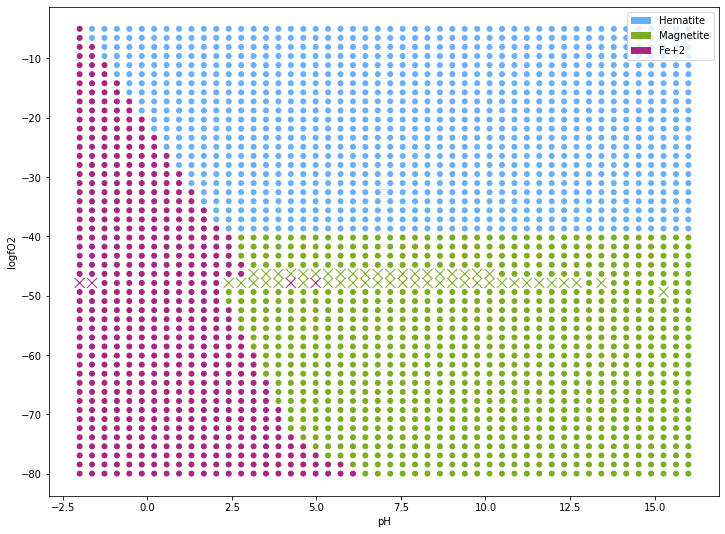

In [397]:
points_plot = np.meshgrid(pH_values, np.log10(fO2_values))

fig, ax = plt.subplots(figsize=(12,9))

def unpack(x, y): 
    return x[0], y[0] 
    
x, y = unpack(*zip(dim.flatten() for dim in points_plot))
mscatter(x, y, ax=ax, c=colors, m=markers, s=100)

# add legend
recs = []
for i in range(len(color_hex)):
    recs.append(mpatches.Rectangle((0,0),1,1, fc=color_hex[i]))
ax.legend(recs, substances, loc="upper right")
ax.set_xlabel("pH")
ax.set_ylabel("logfO2");

## Calculate hematite-magnetite phase boundary using model reaction

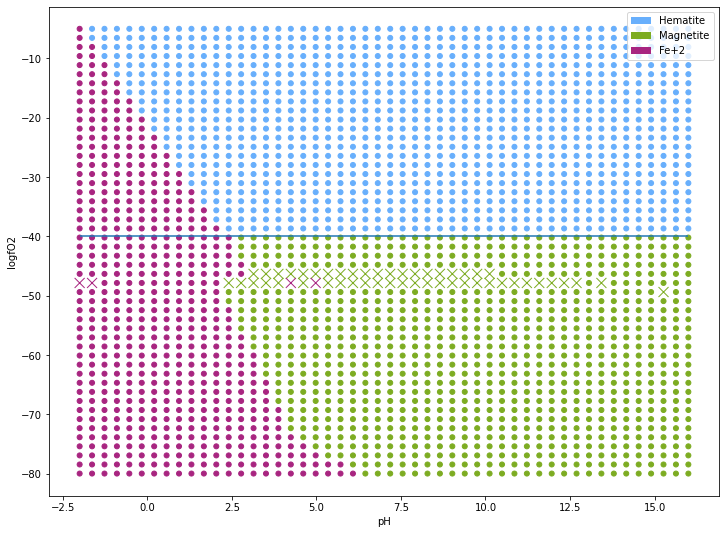

In [398]:
rxn = db.reaction("3*Hematite = 2*Magnetite + 0.5*O2")
lgK = rxn.props(T, P).lgK[0]
lgfO2 = 2*lgK

ax.hlines(lgfO2, -2, 16)
fig

## Calculate hematite-magnetite phase boundary using equilibrium constraint

### Set up the specifications for the equilibrium solver and add general constraints

In [399]:
specs = rkt.EquilibriumSpecs(system)

specs.temperature()   
specs.pressure()
specs.pH()

### Create functions to establish phase boundary constraint

In [400]:
def get_phase_amount_diff(props, phase1, phase2): 
    diff = props.phaseProps(phase1).mass() - props.phaseProps(phase2).mass()

    return diff

def add_equal_phase_amount_constraint(specs, phase1, phase2): 
    idxp_amount_diff = specs.addInput("phase_amount_diff")  # add symbol for a new input condition to the equilibrium problem

    equal_phase_amount_constraint = rkt.ConstraintEquation()
    equal_phase_amount_constraint.id = "Equal Phase Amount Constraint"  # give some identification name to the constraint
    equal_phase_amount_constraint.fn = lambda props, w: get_phase_amount_diff(props, phase1, phase2) - w[idxp_amount_diff]  # the residual function 

    specs.addConstraint(equal_phase_amount_constraint)

    return specs

## Add phase boundary constraint

In [401]:
add_equal_phase_amount_constraint(specs, "Hematite", "Magnetite")
specs.openTo("O2")

## Calculate equilibrium for range of pH values; save the corresponding fO2 values for plotting

In [402]:
solver = rkt.EquilibriumSolver(specs)
conditions = rkt.EquilibriumConditions(specs)

pH_values = np.linspace(-2, 16, 10)
fO2_values = []

opts = rkt.EquilibriumOptions()
opts.epsilon = 1e-80

for pH in pH_values: 
    solver = rkt.EquilibriumSolver(specs)
    conditions = rkt.EquilibriumConditions(specs)

    conditions.temperature(T, "K")
    conditions.pressure(rkt.waterSaturationPressureWagnerPruss(T))
    conditions.pH(pH) 

    state = rkt.ChemicalState(system) # initialize system
    state.set("H2O@",  1, "kg")
    state.set("Magnetite", 1, "mol")

    solver.setOptions(opts)
    result = solver.solve(state, conditions)
    print(result.optima.succeeded)
    props = rkt.ChemicalProps(state)
    
    fO2_values.append(float(rkt.ChemicalProps(state).speciesActivity("O2@")))

True
True
True
True
True
True
True
True
True
True


## Plot calculated hematite-magnetite phase boundary
Note that, except where it deviates at very high and very low ph<> the fO2 value of the plotted boundary roughly corresponds to machine precision, but I thought that this should no longer be an issue for fO2?

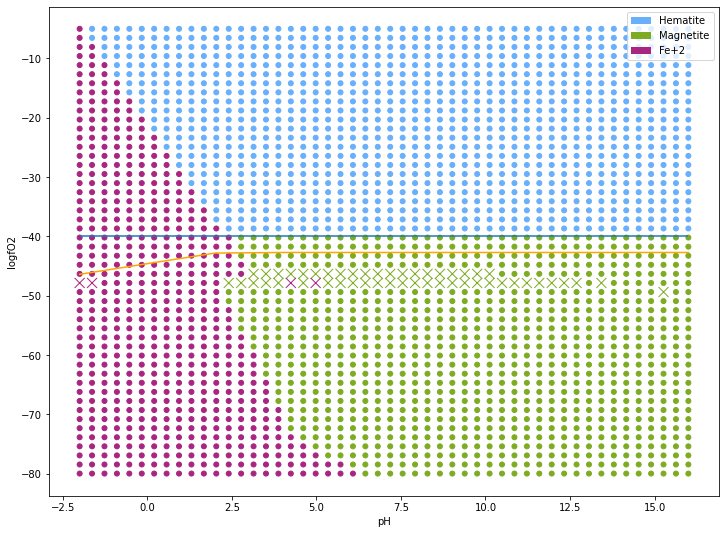

In [403]:
ax.plot(pH_values, np.log10(fO2_values), color="orange")
fig